<a href="https://colab.research.google.com/github/HesterFrederiek/Hackaton_Zurich/blob/master/geodaten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages 

In [35]:
import json
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [36]:
!pip install geopandas

In [37]:
import geopandas
from shapely.geometry import Point, Polygon

# Code to flatten nested json file 

Code copied from: https://stackoverflow.com/questions/39899005/how-to-flatten-a-pandas-dataframe-with-some-columns-as-json

In [38]:
def flatten_nested_json_df(df):

    df = df.reset_index()

    print(f"original shape: {df.shape}")
    print(f"original columns: {df.columns}")


    # search for columns to explode/flatten
    s = (df.applymap(type) == list).all()
    list_columns = s[s].index.tolist()

    s = (df.applymap(type) == dict).all()
    dict_columns = s[s].index.tolist()

    print(f"lists: {list_columns}, dicts: {dict_columns}")
    while len(list_columns) > 0 or len(dict_columns) > 0:
        new_columns = []

        for col in dict_columns:
            print(f"flattening: {col}")
            # explode dictionaries horizontally, adding new columns
            horiz_exploded = pd.json_normalize(df[col]).add_prefix(f'{col}.')
            horiz_exploded.index = df.index
            df = pd.concat([df, horiz_exploded], axis=1).drop(columns=[col])
            new_columns.extend(horiz_exploded.columns) # inplace

        for col in list_columns:
            print(f"exploding: {col}")
            # explode lists vertically, adding new columns
            df = df.drop(columns=[col]).join(df[col].explode().to_frame())
            new_columns.append(col)

        # check if there are still dict o list fields to flatten
        s = (df[new_columns].applymap(type) == list).all()
        list_columns = s[s].index.tolist()

        s = (df[new_columns].applymap(type) == dict).all()
        dict_columns = s[s].index.tolist()

        print(f"lists: {list_columns}, dicts: {dict_columns}")

    print(f"final shape: {df.shape}")
    print(f"final columns: {df.columns}")
    return df

# Import data bfe ladestellen

In [39]:
url = 'https://data.geo.admin.ch/ch.bfe.ladestellen-elektromobilitaet/data/oicp/ch.bfe.ladestellen-elektromobilitaet.json'

In [40]:
data = requests.get(url).json()

df = pd.DataFrame(data["EVSEData"])

# Extract locations of charging stations


In [41]:
df2 = pd.json_normalize(data["EVSEData"])

In [42]:
df_flat = flatten_nested_json_df(df2)
df_flat = df_flat.reset_index()
addresses = df_flat["EVSEDataRecord"]
# get geocoordinates of charging station (here for the first one): [float(x) for x in addresses[0]["GeoCoordinates"]['Google'].split()

original shape: (31, 4)
original columns: Index(['index', 'EVSEDataRecord', 'OperatorID', 'OperatorName'], dtype='object')
lists: ['EVSEDataRecord'], dicts: []
exploding: EVSEDataRecord
lists: [], dicts: []
final shape: (6627, 4)
final columns: Index(['index', 'OperatorID', 'OperatorName', 'EVSEDataRecord'], dtype='object')


# Import geojson "Statistische Raumeinheiten: Wohnviertel" from open data portal bs



In [43]:
url = "https://data.bs.ch/explore/dataset/100042/download/?format=geojson&timezone=Europe/Berlin&lang=de"

In [44]:
gdf = geopandas.read_file(url)

# Explore data

In [45]:
gdf

,wov_id,wov_name,gemeinde_name,wov_label,geometry
0,10,Iselin,Basel,10,"POLYGON ((7.56475 47.55712, 7.56458 47.55711, ..."
1,11,St. Johann,Basel,11,"POLYGON ((7.57364 47.56210, 7.57305 47.56238, ..."
2,13,Clara,Basel,13,"POLYGON ((7.59783 47.56054, 7.59734 47.56025, ..."
3,15,Hirzbrunnen,Basel,15,"POLYGON ((7.61369 47.55876, 7.61362 47.55875, ..."
4,17,Matthäus,Basel,17,"POLYGON ((7.59399 47.56504, 7.59272 47.56466, ..."
5,20,Riehen,Riehen,20,"POLYGON ((7.64959 47.56054, 7.64931 47.56041, ..."
6,30,Bettingen,Bettingen,30,"POLYGON ((7.65237 47.56212, 7.65251 47.56221, ..."
7,02,Vorstädte,Basel,2,"POLYGON ((7.58713 47.55098, 7.58710 47.55104, ..."
8,05,St. Alban,Basel,5,"POLYGON ((7.60569 47.53056, 7.60558 47.53042, ..."
9,06,Gundeldingen,Basel,6,"POLYGON ((7.60405 47.53743, 7.60410 47.53733, ..."


In [46]:
gdf.geometry

0     POLYGON ((7.56475 47.55712, 7.56458 47.55711, ...
1     POLYGON ((7.57364 47.56210, 7.57305 47.56238, ...
2     POLYGON ((7.59783 47.56054, 7.59734 47.56025, ...
3     POLYGON ((7.61369 47.55876, 7.61362 47.55875, ...
4     POLYGON ((7.59399 47.56504, 7.59272 47.56466, ...
5     POLYGON ((7.64959 47.56054, 7.64931 47.56041, ...
6     POLYGON ((7.65237 47.56212, 7.65251 47.56221, ...
7     POLYGON ((7.58713 47.55098, 7.58710 47.55104, ...
8     POLYGON ((7.60569 47.53056, 7.60558 47.53042, ...
9     POLYGON ((7.60405 47.53743, 7.60410 47.53733, ...
10    POLYGON ((7.59484 47.51934, 7.59479 47.51930, ...
11    POLYGON ((7.57632 47.54392, 7.57601 47.54394, ...
12    POLYGON ((7.57421 47.55335, 7.57411 47.55333, ...
13    POLYGON ((7.60231 47.55683, 7.60072 47.55676, ...
14    POLYGON ((7.60031 47.56223, 7.60018 47.56216, ...
15    POLYGON ((7.59539 47.55581, 7.59552 47.55576, ...
16    POLYGON ((7.58553 47.55216, 7.58584 47.55206, ...
17    POLYGON ((7.62252 47.54272, 7.62250 47.542

In [47]:
gdf.geometry.geom_type

0     Polygon
1     Polygon
2     Polygon
3     Polygon
4     Polygon
5     Polygon
6     Polygon
7     Polygon
8     Polygon
9     Polygon
10    Polygon
11    Polygon
12    Polygon
13    Polygon
14    Polygon
15    Polygon
16    Polygon
17    Polygon
18    Polygon
19    Polygon
20    Polygon
dtype: object

In [48]:
point = Point([7.58887566398, 47.5570843667])

In [49]:
type(point)

shapely.geometry.point.Point

In [50]:
type(gdf.geometry[0])

shapely.geometry.polygon.Polygon

In [51]:
polygon = gdf.geometry[0]

In [52]:
polygon.contains(point)

False

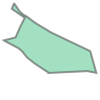

In [53]:
gdf.geometry[0]

# Identify locations of charging stations

Find the charging stations in Basel, checked that I got the same number (67) as Christian (https://github.com/statistikZH/geocoords2spatialunits), checked the lines that gave errors 

In [54]:
k = 0
for i in range(len(addresses)): #range(len(addresses)):
  try: 
    addresses[i]["GeoCoordinates"]['Google'].split()
    #print(i)
    coordinates = [float(x) for x in addresses[i]["GeoCoordinates"]['Google'].split()]
    point = Point(coordinates[1], coordinates[0])
    for j in range(len(gdf.geometry)):
      polygon = gdf.geometry[j]
      if polygon.contains(point):
        print(i, gdf["wov_name"][j], gdf["wov_id"][j])
        k += 1
  except: 
    TypeError
    print("error with " ,i)
print(k)

error with  71
error with  72
417 Rosental 16
418 Rosental 16
635 Hirzbrunnen 15
636 Hirzbrunnen 15
637 Hirzbrunnen 15
638 Hirzbrunnen 15
773 Bettingen 30
774 Bettingen 30
918 Gundeldingen 06
919 Gundeldingen 06
1041 Am Ring 03
1042 Am Ring 03
1117 Vorstädte 02
1118 Vorstädte 02
1119 Vorstädte 02
1120 Altstadt Grossbasel 01
1121 Vorstädte 02
1122 Vorstädte 02
1123 Vorstädte 02
1124 Vorstädte 02
1198 St. Alban 05
1199 St. Alban 05
1244 Riehen 20
1245 Riehen 20
1250 Gundeldingen 06
1251 Gundeldingen 06
1254 St. Alban 05
1255 St. Alban 05
1256 St. Alban 05
1257 St. Alban 05
1286 St. Alban 05
1287 St. Alban 05
1304 Gundeldingen 06
1305 Gundeldingen 06
1306 Gundeldingen 06
1373 Bruderholz 07
1374 Bruderholz 07
1375 Bruderholz 07
1376 Bruderholz 07
1379 St. Alban 05
1380 St. Alban 05
1381 Hirzbrunnen 15
1382 Hirzbrunnen 15
1388 St. Alban 05
1389 St. Alban 05
1390 St. Johann 11
1391 St. Johann 11
1392 Bachletten 08
1393 Bachletten 08
1593 Breite 04
1594 Breite 04
1595 St. Johann 11
1596 St. J

# Create new dataframe for charging stations per quarter

## add "SPATIAL_UNIT" and "Ladestationen" column to gdf dataframe with wohnviertel info

In [55]:
gdf["SPATIAL_UNIT"] = np.array([int(x) for x in gdf["wov_label"]]) + 1200 
gdf["Ladestationen"] = np.zeros(21).astype(int)
gdf

,wov_id,wov_name,gemeinde_name,wov_label,geometry,SPATIAL_UNIT,Ladestationen
0,10,Iselin,Basel,10,"POLYGON ((7.56475 47.55712, 7.56458 47.55711, ...",1210,0
1,11,St. Johann,Basel,11,"POLYGON ((7.57364 47.56210, 7.57305 47.56238, ...",1211,0
2,13,Clara,Basel,13,"POLYGON ((7.59783 47.56054, 7.59734 47.56025, ...",1213,0
3,15,Hirzbrunnen,Basel,15,"POLYGON ((7.61369 47.55876, 7.61362 47.55875, ...",1215,0
4,17,Matthäus,Basel,17,"POLYGON ((7.59399 47.56504, 7.59272 47.56466, ...",1217,0
5,20,Riehen,Riehen,20,"POLYGON ((7.64959 47.56054, 7.64931 47.56041, ...",1220,0
6,30,Bettingen,Bettingen,30,"POLYGON ((7.65237 47.56212, 7.65251 47.56221, ...",1230,0
7,02,Vorstädte,Basel,2,"POLYGON ((7.58713 47.55098, 7.58710 47.55104, ...",1202,0
8,05,St. Alban,Basel,5,"POLYGON ((7.60569 47.53056, 7.60558 47.53042, ...",1205,0
9,06,Gundeldingen,Basel,6,"POLYGON ((7.60405 47.53743, 7.60410 47.53733, ...",1206,0


In [56]:
k = 0
for i in range(len(addresses)): #range(len(addresses)):
  try: 
    addresses[i]["GeoCoordinates"]['Google'].split()
    coordinates = [float(x) for x in addresses[i]["GeoCoordinates"]['Google'].split()]
    point = Point(coordinates[1], coordinates[0])
    for j in range(len(gdf.geometry)):
      polygon = gdf.geometry[j]
      if polygon.contains(point):
        gdf.loc[j, "Ladestationen"] = gdf.loc[j, "Ladestationen"] + 1
  except: 
    TypeError

In [57]:
gdf

,wov_id,wov_name,gemeinde_name,wov_label,geometry,SPATIAL_UNIT,Ladestationen
0,10,Iselin,Basel,10,"POLYGON ((7.56475 47.55712, 7.56458 47.55711, ...",1210,0
1,11,St. Johann,Basel,11,"POLYGON ((7.57364 47.56210, 7.57305 47.56238, ...",1211,4
2,13,Clara,Basel,13,"POLYGON ((7.59783 47.56054, 7.59734 47.56025, ...",1213,0
3,15,Hirzbrunnen,Basel,15,"POLYGON ((7.61369 47.55876, 7.61362 47.55875, ...",1215,6
4,17,Matthäus,Basel,17,"POLYGON ((7.59399 47.56504, 7.59272 47.56466, ...",1217,0
5,20,Riehen,Riehen,20,"POLYGON ((7.64959 47.56054, 7.64931 47.56041, ...",1220,2
6,30,Bettingen,Bettingen,30,"POLYGON ((7.65237 47.56212, 7.65251 47.56221, ...",1230,2
7,02,Vorstädte,Basel,2,"POLYGON ((7.58713 47.55098, 7.58710 47.55104, ...",1202,7
8,05,St. Alban,Basel,5,"POLYGON ((7.60569 47.53056, 7.60558 47.53042, ...",1205,19
9,06,Gundeldingen,Basel,6,"POLYGON ((7.60405 47.53743, 7.60410 47.53733, ...",1206,8


## Get population from https://data.bs.ch/explore/dataset/100060/table/?sort=-jahr

In [58]:
url_pop = "https://data.bs.ch/explore/dataset/100060/download/?format=csv&timezone=Europe/Berlin&lang=de&use_labels_for_header=true&csv_separator=%3B"
df_pop = pd.read_csv(url_pop, sep=";")
df_pop.head() 

,WOV_NAME,Wohnviertel,WOV_LABEL,Geo Shape,Geo Point,Jahr,Anteil Ausländer,Anteil Kantonsbürger,Anteil Kantonsbürger an der Schweizer Bevölkerung,Anteil Schweizer,Anzahl Ausländer,Anzahl Kantonsbürger,Anzahl Schweizer,Anzahl Gesamtbevölkerung,gemeinde_name
0,Altstadt Grossbasel,1,1,"{""type"": ""Polygon"", ""coordinates"": [[[7.595387...","47.5570843667,7.58887566398",2002,19.1,43.3,53.6,80.9,400,907,1693,2093,Basel
1,Altstadt Grossbasel,1,1,"{""type"": ""Polygon"", ""coordinates"": [[[7.595387...","47.5570843667,7.58887566398",2005,22.4,39.9,51.4,77.6,466,831,1618,2084,Basel
2,Altstadt Grossbasel,1,1,"{""type"": ""Polygon"", ""coordinates"": [[[7.595387...","47.5570843667,7.58887566398",2009,24.6,40.3,53.4,75.4,487,798,1495,1982,Basel
3,Altstadt Grossbasel,1,1,"{""type"": ""Polygon"", ""coordinates"": [[[7.595387...","47.5570843667,7.58887566398",2011,26.2,40.2,54.5,73.8,521,800,1469,1990,Basel
4,Altstadt Grossbasel,1,1,"{""type"": ""Polygon"", ""coordinates"": [[[7.595387...","47.5570843667,7.58887566398",2015,27.2,38.0,52.3,72.8,568,793,1517,2085,Basel


In [59]:
df_pop = df_pop[df_pop["Jahr"] == 2019]
df_pop = df_pop[["WOV_NAME", "WOV_LABEL", "Anzahl Gesamtbevölkerung", "Jahr"]].reset_index()
df_pop_new = df_pop.rename({'WOV_LABEL': "wov_label"}, axis=1)
type(df_pop_new["wov_label"][2])
gdf["wov_label"] = [int(x) for x in gdf["wov_label"]]
type(gdf["wov_label"][2])

numpy.int64



```
# Als Code formatiert
```

## Add Population info to dataframe

In [60]:
df_charging = pd.merge(df_pop_new, gdf, left_on="wov_label", right_on = "wov_label")
df_charging

,index,WOV_NAME,wov_label,Anzahl Gesamtbevölkerung,Jahr,wov_id,wov_name,gemeinde_name,geometry,SPATIAL_UNIT,Ladestationen
0,27,Am Ring,3,11120,2019,03,Am Ring,Basel,"POLYGON ((7.58553 47.55216, 7.58584 47.55206, ...",1203,3
1,48,Bachletten,8,13657,2019,08,Bachletten,Basel,"POLYGON ((7.57632 47.54392, 7.57601 47.54394, ...",1208,2
2,64,Iselin,10,16890,2019,10,Iselin,Basel,"POLYGON ((7.56475 47.55712, 7.56458 47.55711, ...",1210,0
3,79,Altstadt Kleinbasel,12,2409,2019,12,Altstadt Kleinbasel,Basel,"POLYGON ((7.59071 47.56053, 7.59064 47.56060, ...",1212,2
4,89,Wettstein,14,5525,2019,14,Wettstein,Basel,"POLYGON ((7.60231 47.55683, 7.60072 47.55676, ...",1214,0
5,101,Rosental,16,7542,2019,16,Rosental,Basel,"POLYGON ((7.60031 47.56223, 7.60018 47.56216, ...",1216,2
6,110,Matthäus,17,15275,2019,17,Matthäus,Basel,"POLYGON ((7.59399 47.56504, 7.59272 47.56466, ...",1217,0
7,125,Kleinhüningen,19,2798,2019,19,Kleinhüningen,Basel,"POLYGON ((7.58707 47.58288, 7.58706 47.58289, ...",1219,0
8,152,Vorstädte,2,5019,2019,02,Vorstädte,Basel,"POLYGON ((7.58713 47.55098, 7.58710 47.55104, ...",1202,7
9,164,Breite,4,9014,2019,04,Breite,Basel,"POLYGON ((7.62252 47.54272, 7.62250 47.54243, ...",1204,2


In [61]:
df_charging = df_charging[df_charging["gemeinde_name"] == "Basel"].reset_index()
df_charging

,level_0,index,WOV_NAME,wov_label,Anzahl Gesamtbevölkerung,Jahr,wov_id,wov_name,gemeinde_name,geometry,SPATIAL_UNIT,Ladestationen
0,0,27,Am Ring,3,11120,2019,03,Am Ring,Basel,"POLYGON ((7.58553 47.55216, 7.58584 47.55206, ...",1203,3
1,1,48,Bachletten,8,13657,2019,08,Bachletten,Basel,"POLYGON ((7.57632 47.54392, 7.57601 47.54394, ...",1208,2
2,2,64,Iselin,10,16890,2019,10,Iselin,Basel,"POLYGON ((7.56475 47.55712, 7.56458 47.55711, ...",1210,0
3,3,79,Altstadt Kleinbasel,12,2409,2019,12,Altstadt Kleinbasel,Basel,"POLYGON ((7.59071 47.56053, 7.59064 47.56060, ...",1212,2
4,4,89,Wettstein,14,5525,2019,14,Wettstein,Basel,"POLYGON ((7.60231 47.55683, 7.60072 47.55676, ...",1214,0
5,5,101,Rosental,16,7542,2019,16,Rosental,Basel,"POLYGON ((7.60031 47.56223, 7.60018 47.56216, ...",1216,2
6,6,110,Matthäus,17,15275,2019,17,Matthäus,Basel,"POLYGON ((7.59399 47.56504, 7.59272 47.56466, ...",1217,0
7,7,125,Kleinhüningen,19,2798,2019,19,Kleinhüningen,Basel,"POLYGON ((7.58707 47.58288, 7.58706 47.58289, ...",1219,0
8,8,152,Vorstädte,2,5019,2019,02,Vorstädte,Basel,"POLYGON ((7.58713 47.55098, 7.58710 47.55104, ...",1202,7
9,9,164,Breite,4,9014,2019,04,Breite,Basel,"POLYGON ((7.62252 47.54272, 7.62250 47.54243, ...",1204,2


In [62]:
df_charging["population_per_1000"] =  df_charging["Anzahl Gesamtbevölkerung"]/1000
df_charging

,level_0,index,WOV_NAME,wov_label,Anzahl Gesamtbevölkerung,Jahr,wov_id,wov_name,gemeinde_name,geometry,SPATIAL_UNIT,Ladestationen,population_per_1000
0,0,27,Am Ring,3,11120,2019,03,Am Ring,Basel,"POLYGON ((7.58553 47.55216, 7.58584 47.55206, ...",1203,3,11.120
1,1,48,Bachletten,8,13657,2019,08,Bachletten,Basel,"POLYGON ((7.57632 47.54392, 7.57601 47.54394, ...",1208,2,13.657
2,2,64,Iselin,10,16890,2019,10,Iselin,Basel,"POLYGON ((7.56475 47.55712, 7.56458 47.55711, ...",1210,0,16.890
3,3,79,Altstadt Kleinbasel,12,2409,2019,12,Altstadt Kleinbasel,Basel,"POLYGON ((7.59071 47.56053, 7.59064 47.56060, ...",1212,2,2.409
4,4,89,Wettstein,14,5525,2019,14,Wettstein,Basel,"POLYGON ((7.60231 47.55683, 7.60072 47.55676, ...",1214,0,5.525
5,5,101,Rosental,16,7542,2019,16,Rosental,Basel,"POLYGON ((7.60031 47.56223, 7.60018 47.56216, ...",1216,2,7.542
6,6,110,Matthäus,17,15275,2019,17,Matthäus,Basel,"POLYGON ((7.59399 47.56504, 7.59272 47.56466, ...",1217,0,15.275
7,7,125,Kleinhüningen,19,2798,2019,19,Kleinhüningen,Basel,"POLYGON ((7.58707 47.58288, 7.58706 47.58289, ...",1219,0,2.798
8,8,152,Vorstädte,2,5019,2019,02,Vorstädte,Basel,"POLYGON ((7.58713 47.55098, 7.58710 47.55104, ...",1202,7,5.019
9,9,164,Breite,4,9014,2019,04,Breite,Basel,"POLYGON ((7.62252 47.54272, 7.62250 47.54243, ...",1204,2,9.014


[Linktext](https://)

## Create and export dataframes in right format for Zurich Hackathon


In [63]:
df_ladestationen_wohnviertel = pd.DataFrame(columns=["INDICATOR_ID", "SPATIALUNIT_ID", "YEAR", "VALUE", "VALUE_ADDITION", "CAT"])
df_ladestationen_wohnviertel_per_1000 = pd.DataFrame(columns=["INDICATOR_ID", "SPATIALUNIT_ID", "YEAR", "VALUE", "VALUE_ADDITION", "CAT"])

VALUE_ADDITION = np.nan
CAT = str(datetime.datetime.today().strftime('%d.%m.%y %H:%M'))


In [64]:
df_ladestationen_wohnviertel["YEAR"] =  np.full(19, 2021)
df_ladestationen_wohnviertel["INDICATOR_ID"] = np.full(19, 999)
df_ladestationen_wohnviertel["SPATIALUNIT_ID"] = df_charging["SPATIAL_UNIT"]
df_ladestationen_wohnviertel["VALUE_ADDITION"] = VALUE_ADDITION
df_ladestationen_wohnviertel["CAT"] = CAT
df_ladestationen_wohnviertel["VALUE"] = df_charging["Ladestationen"]
df_ladestationen_wohnviertel



,INDICATOR_ID,SPATIALUNIT_ID,YEAR,VALUE,VALUE_ADDITION,CAT
0,999,1203,2021,3,NaN,14.10.21 15:53
1,999,1208,2021,2,NaN,14.10.21 15:53
2,999,1210,2021,0,NaN,14.10.21 15:53
3,999,1212,2021,2,NaN,14.10.21 15:53
4,999,1214,2021,0,NaN,14.10.21 15:53
5,999,1216,2021,2,NaN,14.10.21 15:53
6,999,1217,2021,0,NaN,14.10.21 15:53
7,999,1219,2021,0,NaN,14.10.21 15:53
8,999,1202,2021,7,NaN,14.10.21 15:53
9,999,1204,2021,2,NaN,14.10.21 15:53


In [65]:
df_ladestationen_wohnviertel_per_1000["YEAR"] =  np.full(19, 2021)
df_ladestationen_wohnviertel_per_1000["INDICATOR_ID"] = np.full(19,998)
df_ladestationen_wohnviertel_per_1000["SPATIALUNIT_ID"] = df_charging["SPATIAL_UNIT"]
df_ladestationen_wohnviertel_per_1000["VALUE_ADDITION"] = VALUE_ADDITION
df_ladestationen_wohnviertel_per_1000["CAT"] = CAT
df_ladestationen_wohnviertel_per_1000["VALUE"] = df_charging["Ladestationen"]/df_charging["population_per_1000"]
df_ladestationen_wohnviertel_per_1000

,INDICATOR_ID,SPATIALUNIT_ID,YEAR,VALUE,VALUE_ADDITION,CAT
0,998,1203,2021,0.269784,NaN,14.10.21 15:53
1,998,1208,2021,0.146445,NaN,14.10.21 15:53
2,998,1210,2021,0.000000,NaN,14.10.21 15:53
3,998,1212,2021,0.830220,NaN,14.10.21 15:53
4,998,1214,2021,0.000000,NaN,14.10.21 15:53
5,998,1216,2021,0.265182,NaN,14.10.21 15:53
6,998,1217,2021,0.000000,NaN,14.10.21 15:53
7,998,1219,2021,0.000000,NaN,14.10.21 15:53
8,998,1202,2021,1.394700,NaN,14.10.21 15:53
9,998,1204,2021,0.221877,NaN,14.10.21 15:53


In [66]:
df_ladestationen_wohnviertel.to_csv("ladestationen_wohnviertel.csv", index_label=False)
df_ladestationen_wohnviertel_per_1000.to_csv("ladestationen_wohnviertel_per_1000.csv", index_label=False)

In [67]:
df1 = pd.read_csv("ladestationen_wohnviertel.csv", index_col=None)
df1

,INDICATOR_ID,SPATIALUNIT_ID,YEAR,VALUE,VALUE_ADDITION,CAT
0,999,1203,2021,3,NaN,14.10.21 15:53
1,999,1208,2021,2,NaN,14.10.21 15:53
2,999,1210,2021,0,NaN,14.10.21 15:53
3,999,1212,2021,2,NaN,14.10.21 15:53
4,999,1214,2021,0,NaN,14.10.21 15:53
5,999,1216,2021,2,NaN,14.10.21 15:53
6,999,1217,2021,0,NaN,14.10.21 15:53
7,999,1219,2021,0,NaN,14.10.21 15:53
8,999,1202,2021,7,NaN,14.10.21 15:53
9,999,1204,2021,2,NaN,14.10.21 15:53
